## Baseline Modeling

Author: Calvin Chan 

### Introduction
In this notebook, we will go over a few baseline models to test out our data. Instead of using the whole data set, we will only be working with a sample of it using a function in our `functions.py` file. 

### Table of Contents
- [Logistic Regression](#logreg)
- [Simple Neural Network](#ann)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import load_functions as f

import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

Let's load a sample of our data set and feed it into a Logistic Regression and a simple neural network.

In [ ]:
# File path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Load sample data using high frequency
X_sample, y_sample = f.load_sample_signal(5000, path, metadata, random_state=42)

Below we have the option of reshaping our data if we wish to by flattening the 12 leads out. Otherwise we set Lead II as the signal we look at for all ECG signals.

In [ ]:
# Reshaping 

# Flattening all 12 leads to be side by side
# X_sample = X_sample.reshape(100, -1)

# Only looking at Lead II
X_sample = X_sample[:,:,1]

X_sample.shape

We also need to change our labels in our target column to numerical values. We can do that using `LabelEncoder()`.

In [ ]:
# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y_sample)

# Transform target column 
y_sample = label.transform(y_sample)

Now we are ready to do the train-test split. We will use 80-20 for our training and testing data, making sure we have all our categories in both train and test set. 

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42)

In [ ]:
# Unique categories in train
np.unique(y_train)

In [ ]:
# Unique categories in test
np.unique(y_test)

In [ ]:
# Example signal
sig_len = X_sample.shape[1]
sampling_frequency = 100

# Set time axis
time = np.arange(0, sig_len) / sampling_frequency

# Plot a sample signal 
plt.figure(figsize=(15,5))
plt.plot(time, X_sample[0,:])
plt.title("Sample Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.show()

In [ ]:
time

<a id='logreg'></a>
### Logistic Regression

We are ready for modelling, starting with Logistic Regression. We will split our data into bins based on the amplitude and try to classify from there. Visually, this looks like the following

In [ ]:
# Binning with the sample signal above
plt.hist(X_train[0,:], bins=np.linspace(-0.5, 1, 20))
plt.title("Amplitude binning of sample signal")
plt.show()

In [ ]:
# Counts in each bin for the sample signal amplitude
counts, bins = np.histogram(X_train[0,:], bins=np.linspace(-0.5, 1, 20))
counts

Importing the Logistic Regression model from `scikit-learn`

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Instantiate model
logreg = LogisticRegression(max_iter=500)

# Fit model
logreg.fit(X_train, y_train)

# Score
print(f"Training score: {logreg.score(X_train, y_train)}")
print(f"Testing score: {logreg.score(X_test, y_test)}")

As we can see with the scoring Logistic Regression does not do well with our data. This is expected as the signals we are dealing with have a lot of noise. This is also why we need to use Fourier Transforms for our signal before we do modelling. 

<a id='ann'></a>
### Simple Neural Network Classifier
Now we will try something more complicated. Let's build a simple neural network classifier to test out how it behaves on our sample data. We will be using the Keras API in TensorFlow and is structured as followings

In [ ]:
# Instantiate Neural Network 
model = Sequential()

# Add hidden layers
model.add(layers.Dense(5000, activation='relu'))
model.add(layers.Dropout(0.7)) # Adding dropout layers to prevent overfitting
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(25, activation='relu'))

# Output layers
model.add(layers.Dense(5, activation='softmax')) # Since we have 5 classes, we need softmax for probability

In [ ]:
# Compile our model with an optimizer, loss function and metric to look at
model.compile(
    # Optimizer
    optimizer=Adam(learning_rate=0.0005),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[SparseCategoricalAccuracy()]
)

In [ ]:
# Fit our model, adding a validation set as well 
history = model.fit(X_train, y_train, epochs=30, verbose=2, validation_split=0.1,
                    #callbacks=[keras.callbacks.EarlyStopping()]
                   )

In [ ]:
# Looking at our model parameters 
model.summary()

In [ ]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

As we can see from the accuracy scores, our model is still heavily overfit on our training data and is not performing well on our test data. This is even after adding two 70% dropout layers. We can see that even if we use a simple neural network, it still has a hard time distinguishing between the signals. Hence, why we need methods of cleaning our signals such as Fourier Transforms and more complex models to capture these minuscule features. 

Let's plot out our models loss function between the train and test data. 

In [ ]:
# Plotting loss function 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

As we can see from the plot, the model is not learning from the training set, hence the validation loss is increasing as the epochs are increasing. This means that our model is performing poorly on our data and thus refinements need to be made. 

### Simple Neural Network With Full Data Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import wfdb
import load_functions as f
import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

%autosave 300

Autosaving every 300 seconds


In [2]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Import data
full_data = f.load_signal(path, metadata)

In [3]:
# Data shape
full_data[0].shape, full_data[1].shape

((15677, 1000, 12), (15677,))

In [4]:
# Only looking at Lead II

X = full_data[0][:,:,1]

y = full_data[1]

X.shape, y.shape

((15677, 1000), (15677,))

In [29]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal

signal_bl = pd.DataFrame(X).apply(lambda x: c.baseline_removal(x, freq_start=0.1, freq_stop=1.5))
signal_pli = pd.DataFrame(signal_bl).apply(lambda x: c.high_freq_removal(x, freq_start=45))

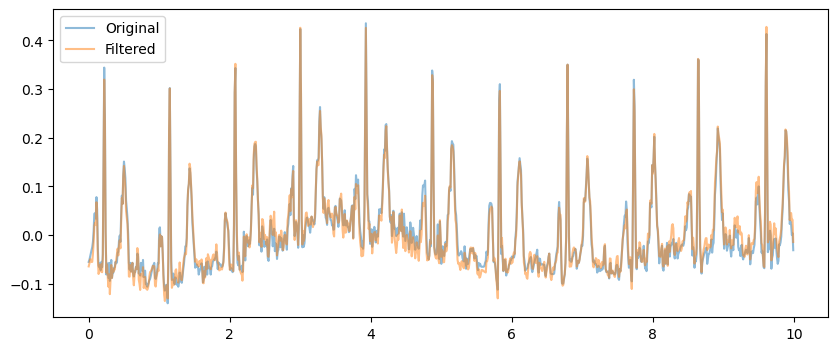

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(time, np.real(X[0]), alpha=0.5, label="Original")
plt.plot(time, np.real(signal_pli.iloc[0]), alpha=0.5, label="Filtered")
plt.legend()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import random as tf_random
from tensorflow import keras
from tensorflow.keras import layers

In [31]:
# Label Encode y data

# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y)

print(label.classes_)

# Transform target column 
y = label.transform(y)

[0 1 2 3 4 5 6 7 8 9]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(signal_pli, y, test_size=0.2, stratify=y, random_state=42)

X_train.shape, y_train.shape

((12541, 1000), (12541,))

In [33]:
# Instantiate Neural Network 
model = keras.Sequential()

# Add hidden layers
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(80, activation='relu'))

# Output layers
model.add(layers.Dense(10, activation='softmax')) # Since we have 10 classes, we need softmax for probability

In [34]:
# Compile our model with an optimizer, loss function and metric to look at
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [35]:
# Fit our model, adding a validation set as well 
history = model.fit(X_train, 
                    y_train, 
                    epochs=30, 
                    verbose=2, 
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                             patience=5)]
)

Epoch 1/30
353/353 - 1s - loss: 1.7199 - sparse_categorical_accuracy: 0.4404 - val_loss: 1.6777 - val_sparse_categorical_accuracy: 0.4669 - 1s/epoch - 3ms/step
Epoch 2/30
353/353 - 1s - loss: 1.6293 - sparse_categorical_accuracy: 0.4460 - val_loss: 1.6611 - val_sparse_categorical_accuracy: 0.4669 - 638ms/epoch - 2ms/step
Epoch 3/30
353/353 - 1s - loss: 1.5885 - sparse_categorical_accuracy: 0.4471 - val_loss: 1.6857 - val_sparse_categorical_accuracy: 0.4629 - 686ms/epoch - 2ms/step
Epoch 4/30
353/353 - 1s - loss: 1.5453 - sparse_categorical_accuracy: 0.4564 - val_loss: 1.6715 - val_sparse_categorical_accuracy: 0.4709 - 695ms/epoch - 2ms/step
Epoch 5/30
353/353 - 1s - loss: 1.4740 - sparse_categorical_accuracy: 0.4715 - val_loss: 1.6908 - val_sparse_categorical_accuracy: 0.4685 - 645ms/epoch - 2ms/step
Epoch 6/30
353/353 - 1s - loss: 1.3826 - sparse_categorical_accuracy: 0.5022 - val_loss: 1.7739 - val_sparse_categorical_accuracy: 0.3817 - 651ms/epoch - 2ms/step
Epoch 7/30
353/353 - 1s -

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 500)               500500    
                                                                 
 dense_4 (Dense)             (None, 80)                40080     
                                                                 
 dense_5 (Dense)             (None, 10)                810       
                                                                 
Total params: 541,390
Trainable params: 541,390
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.5258
Test Accuracy: 0.4117


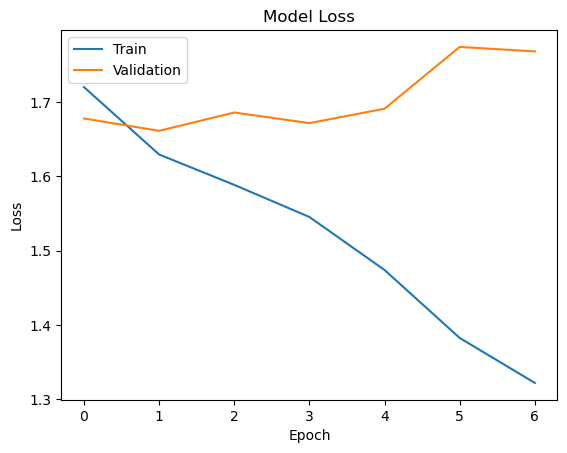

In [38]:
# Plotting loss function 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Confusion Matrix


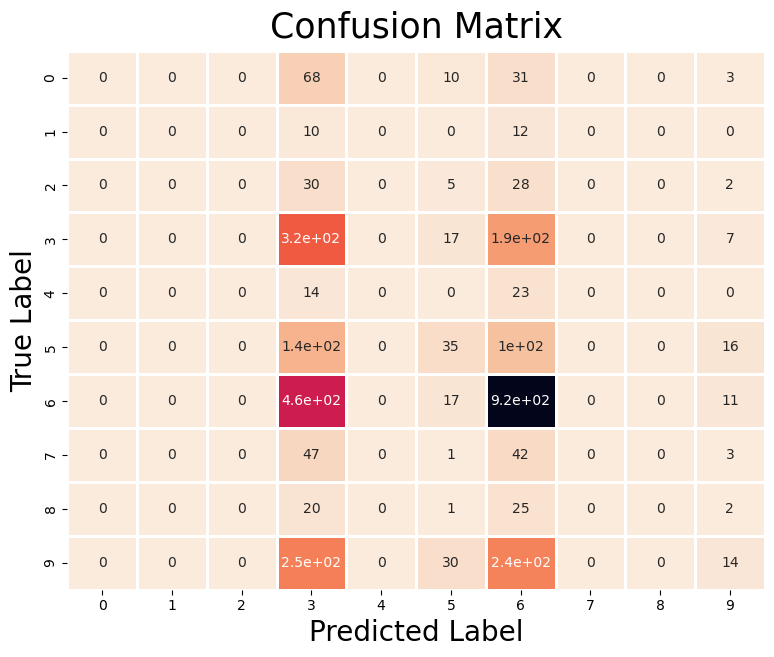

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the predicted labels for each test image.
predict_probas = model.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)

# Create the confusion matrix using sklearn 
conf_mat = confusion_matrix(y_test, y_predict)

# Since we have many images, it is helpful to show our 
# results as fractions of the total number of images 
# for each class.
#normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (9,7))
sns.heatmap(conf_mat,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

In [78]:
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization

rnn_model = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.15),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.15),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(10, activation='softmax')],
)

In [80]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [75]:
X_train_seq = X_train.values.reshape(-1, 1000, 1).astype("float")

/var/folders/hw/t1cnzkgd34db0qbsch9qjy7c0000gn/T/ipykernel_78410/2224386683.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_seq = X_train.values.reshape(-1, 1000, 1).astype("float")


In [92]:
X_train_seq

array([[[-0.15986057],
        [-0.15294382],
        [-0.14074048],
        ...,
        [ 0.04644902],
        [ 0.10132895],
        [ 0.06111396]],

       [[ 0.01134271],
        [-0.01077628],
        [-0.05941718],
        ...,
        [ 0.00925311],
        [-0.00224291],
        [ 0.03724754]],

       [[-0.00130355],
        [-0.01146553],
        [-0.03500876],
        ...,
        [ 0.04404254],
        [ 0.1074987 ],
        [ 0.0969072 ]],

       ...,

       [[-0.04114303],
        [-0.04492946],
        [-0.04284544],
        ...,
        [ 0.06812314],
        [ 0.03700929],
        [-0.0581181 ]],

       [[-0.04171792],
        [-0.03865648],
        [-0.0317378 ],
        ...,
        [ 0.01174304],
        [ 0.0094958 ],
        [ 0.0404805 ]],

       [[-0.14234031],
        [-0.13434854],
        [-0.11733889],
        ...,
        [-0.25538732],
        [-0.27371129],
        [-0.26100319]]])

rnn_model(X_train_seq[:10])

In [83]:
rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (10, 1000, 16)            912       
                                                                 
 batch_normalization_6 (Batc  (10, 1000, 16)           64        
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (10, 1000, 16)            0         
                                                                 
 gru_5 (GRU)                 (10, 16)                  1632      
                                                                 
 batch_normalization_7 (Batc  (10, 16)                 64        
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (10, 16)                 

In [85]:
# Fit our model, adding a validation set as well 
history = rnn_model.fit(X_train_seq, 
                    y_train, 
                    batch_size=32,
                    epochs=30, 
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                             patience=2)]
)

Epoch 1/30
353/353 [==============================] - 194s 550ms/step - loss: 1.6859 - sparse_categorical_accuracy: 0.4334 - val_loss: 1.6607 - val_sparse_categorical_accuracy: 0.4669
Epoch 2/30
353/353 [==============================] - 210s 594ms/step - loss: 1.5594 - sparse_categorical_accuracy: 0.4639 - val_loss: 1.5454 - val_sparse_categorical_accuracy: 0.4996
Epoch 3/30
353/353 [==============================] - 210s 595ms/step - loss: 1.5054 - sparse_categorical_accuracy: 0.4979 - val_loss: 1.6053 - val_sparse_categorical_accuracy: 0.4645
Epoch 4/30
353/353 [==============================] - 201s 570ms/step - loss: 1.5078 - sparse_categorical_accuracy: 0.4880 - val_loss: 1.5199 - val_sparse_categorical_accuracy: 0.5004
Epoch 5/30
353/353 [==============================] - 212s 602ms/step - loss: 1.4743 - sparse_categorical_accuracy: 0.5031 - val_loss: 1.4411 - val_sparse_categorical_accuracy: 0.5267
Epoch 6/30
353/353 [==============================] - 198s 561ms/step - loss: 1.

In [87]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)).astype("float"), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.6145
Test Accuracy: 0.2637


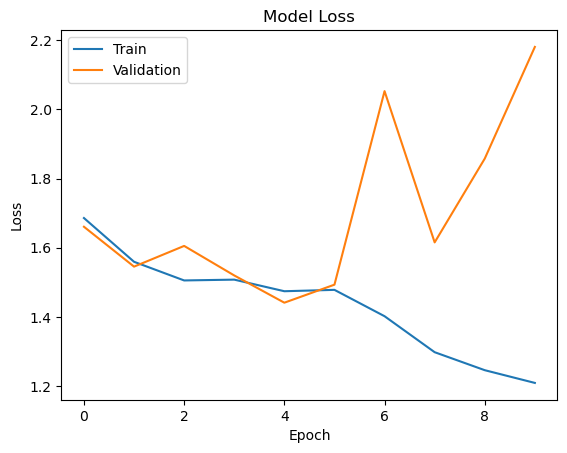

In [88]:
# Plotting loss function 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

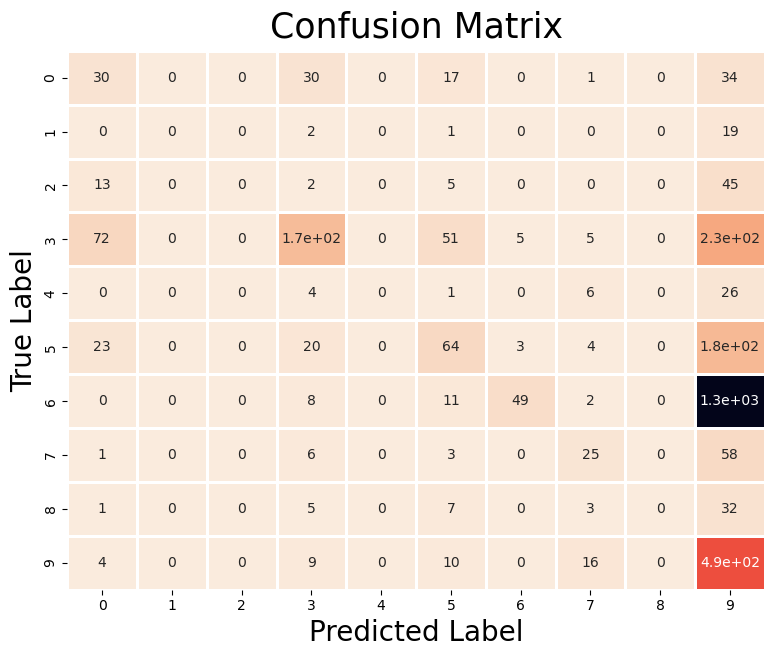

In [90]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model.predict(np.real(X_test.values.reshape(-1, 1000, 1)).astype("float"))
y_predict = np.argmax(predict_probas, axis=1)

# Create the confusion matrix using sklearn 
conf_mat = confusion_matrix(y_test, y_predict)

# Since we have many images, it is helpful to show our 
# results as fractions of the total number of images 
# for each class.
#normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (9,7))
sns.heatmap(conf_mat,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()